In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.optim as optim
from torch import autograd

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 100
task_number = 50
mnist_size = (28, 28)

random_seed = 1
torch.manual_seed(random_seed)

In [3]:
import data

train_datasets, test_datasets = data.get_datasets(random_seed=random_seed,
                                                  task_number=task_number,
                                                  batch_size_train=batch_size_train,
                                                  batch_size_test=batch_size_test)

In [4]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(LinearModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList([
            nn.Linear(self.input_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size)
        ])
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [12]:
def train(model, train_loader, optimizer, epoch, log=False):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.view(len(data), -1))
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if log and batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, test_datasets):
    model.eval()
    test_loss = 0
    correct = 0
    all_data_size = 0
    
    with torch.no_grad():
        for test_loader in test_datasets:
            for data, target in test_loader:
                output = model(data.view(len(data), -1))
                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()
                all_data_size += len(data)
    print(100. * correct / all_data_size)
    return (100. * correct / all_data_size)

In [13]:
model = LinearModel(28 * 28, 10, 100)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

test_acc_linear = []

In [ ]:
for task_no, train_loader in enumerate(train_datasets, 1):
    for epoch in range(1, n_epochs + 1):
        train(model, train_loader, optimizer, epoch, log=True)
        test_acc_linear.append(
            test(model, test_datasets[:task_no])
        )

## EWC

In [19]:
class EWCModel(LinearModel):
    def __init__(self, input_size, output_size,
                 hidden_size=100):
        super().__init__(input_size, output_size, hidden_size)

    def estimate_fisher(self, data_loader):
        loglikelihoods = []
        # iterate through each batch
        for x, y in data_loader:
            x = x.view(len(x), -1)
            loglikelihoods.append(
                F.log_softmax(self(x), dim=0)[range(len(x)), y.data]
            )

        # estimate the fisher information of the parameters.
        loglikelihood = torch.cat(loglikelihoods).mean(dim=0)
        # grad by parametrs
        loglikelihood_grads = autograd.grad(loglikelihood, self.parameters())
        parameter_names = [
            n.replace('.', '__') for n, p in self.named_parameters()
        ]
        return {n: g ** 2 for n, g in zip(parameter_names, loglikelihood_grads)}

    def consolidate(self, fisher):
        for n, p in self.named_parameters():
            n = n.replace('.', '__')
            self.register_buffer('{}_estimated_opt'.format(n), p.data.clone())
            self.register_buffer('{}_estimated_fisher'
                                 .format(n), fisher[n].data.clone())

    def ewc_loss(self, lamda, cuda=False):
        try:
            losses = []
            for param_name, param_val in self.named_parameters():
                # retrieve the consolidated mean and fisher information.
                param_name = param_name.replace('.', '__')
                prev_opt = getattr(self, '{}_estimated_opt'.format(param_name))
                fisher = getattr(self, '{}_estimated_fisher'.format(param_name))
                losses.append((fisher * (param_val - prev_opt) ** 2).sum())
            return (lamda / 2) * sum(losses)
        except AttributeError:
            # ewc loss is 0 if there's no consolidated parameters.
            return (
                Variable(torch.zeros(1))
            )

In [17]:
class EWCModel(nn.Module):
    def __init__(self, input_size, output_size,
                 hidden_size=100):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.layers = nn.ModuleList([
            nn.Linear(self.input_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size), nn.ReLU(),
            nn.Linear(self.hidden_size, self.output_size)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def estimate_fisher(self, data_loader):
        loglikelihoods = []
        # iterate through each batch
        for x, y in data_loader:
            x = x.view(len(x), -1)
            loglikelihoods.append(
                F.log_softmax(self(x), dim=0)[range(len(x)), y.data]
            )

        # estimate the fisher information of the parameters.
        loglikelihood = torch.cat(loglikelihoods).mean(dim=0)
        # grad by parametrs
        loglikelihood_grads = autograd.grad(loglikelihood, self.parameters())
        parameter_names = [
            n.replace('.', '__') for n, p in self.named_parameters()
        ]
        return {n: g ** 2 for n, g in zip(parameter_names, loglikelihood_grads)}

    def consolidate(self, fisher):
        for n, p in self.named_parameters():
            n = n.replace('.', '__')
            self.register_buffer('{}_estimated_opt'.format(n), p.data.clone())
            self.register_buffer('{}_estimated_fisher'
                                 .format(n), fisher[n].data.clone())

    def ewc_loss(self, lamda, cuda=False):
        try:
            losses = []
            for param_name, param_val in self.named_parameters():
                # retrieve the consolidated mean and fisher information.
                param_name = param_name.replace('.', '__')
                prev_opt = getattr(self, '{}_estimated_opt'.format(param_name))
                fisher = getattr(self, '{}_estimated_fisher'.format(param_name))
                losses.append((fisher * (param_val - prev_opt) ** 2).sum())
            return (lamda / 2) * sum(losses)
        except AttributeError:
            # ewc loss is 0 if there's no consolidated parameters.
            return (
                Variable(torch.zeros(1))
            )

In [20]:
model_ewc = EWCModel(28 * 28, 10)
optimizer = optim.SGD(model_ewc.parameters(), lr=learning_rate,
                      momentum=momentum)

test_acc_ewc = []
lamda = 3

In [ ]:
for task_no, train_loader in enumerate(train_datasets, 1):
    for epoch in range(1, n_epochs + 1):
#         trainEWC(model_ewc, train_loader, optimizer, epoch, log=True)
        train(model_ewc, train_loader, optimizer, epoch, log=True)
        test_acc_ewc.append(
            test(model_ewc, test_datasets[:task_no])
        )
    # update Fisher matrix
    model_ewc.consolidate(
        model_ewc.estimate_fisher(train_loader)
                         )


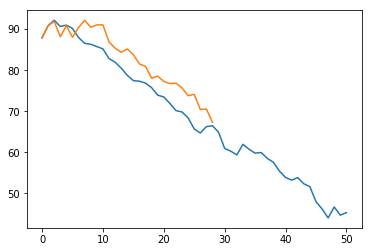

In [0]:
s = 51
plt.plot(test_acc_linear[:s])
plt.plot(test_acc_linear[s:])